In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col

In [16]:
!pip install regex

  Using cached regex-2023.12.25-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
Using cached regex-2023.12.25-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (773 kB)


In [6]:
def plot_gt(data):
    limit = 0.5
    step = 1/1024.0
    pixels = int(2*limit/step)
    grid = np.array([[a, b] for a in np.arange(-limit, limit, step) for b in np.arange(-limit, limit, step)])

    if data =='checkerboard':
        l=[0,2,1,3,0,2,1,3]
        color = np.zeros((pixels,pixels,3))
        for i in range(8):
            y=i//2*256
            x=l[i]*256
            color[x:x+256, y:y+256,0]=i/8.0
            color[x:x+256, y:y+256,2]=1

    color = color.reshape((pixels,pixels,3))

    color[:,:,0]/=(color[:,:,2]+1e-12)
    color[:,:,1]=1
    prob = color[:,:,2].reshape((pixels,pixels))
    prob = prob / np.sum(prob) #normalize the data
    prob+=1e-20
    entropy = - prob * np.log(prob)/np.log(2)
    entropy = np.sum(entropy)
    max_prob = np.max(prob)

    color[:,:,2]/=np.max(color[:,:,2])
    color[:,:,1]=color[:,:,2]
    color = np.clip(color, 0, 1)
    color = col.hsv_to_rgb(color)

    fig = plt.figure(figsize=(18, 18))

    ax1 = fig.add_subplot(1,2,1)
    ax1.axis('off')
    ax1.imshow(prob, extent=(-limit, limit, -limit, limit))

    ax2 = fig.add_subplot(1,2,2)
    ax2.axis('off')
    ax2.imshow(color, extent=(-limit, limit, -limit, limit))

    fig.tight_layout()

    return entropy-20, max_prob, prob, color

Entropy for Checkerboard: -1.000000


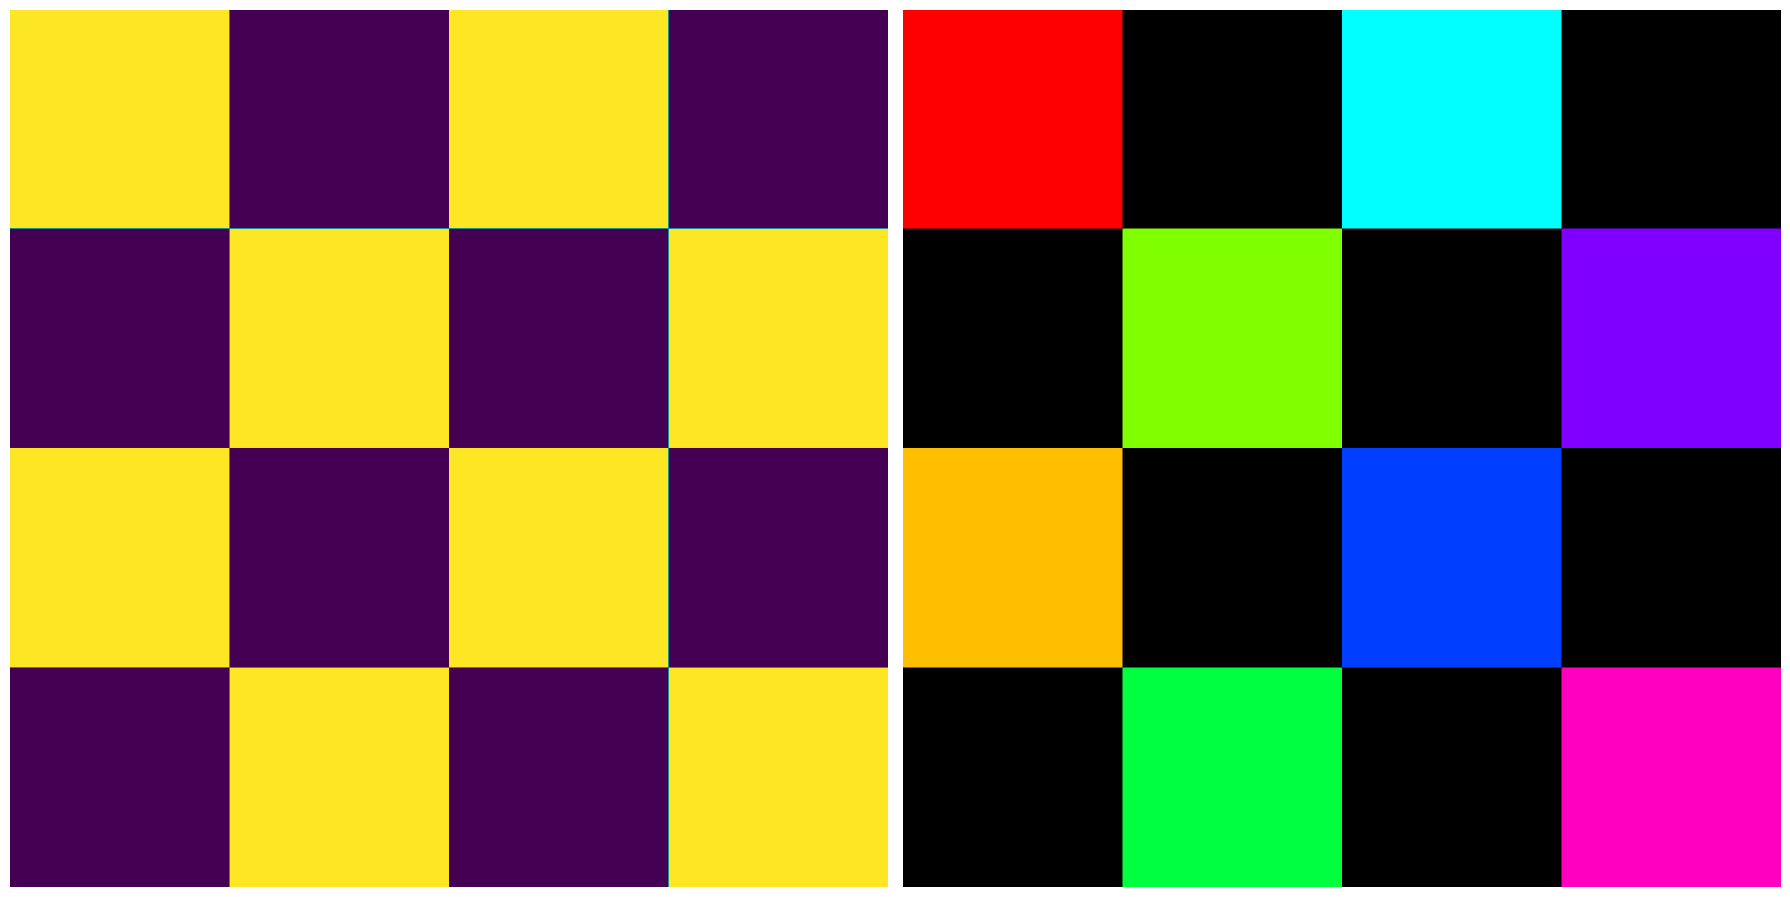

In [7]:
entropyc, max_probc, probc, colorc =plot_gt('checkerboard')
print('Entropy for Checkerboard: {:f}'.format( entropyc))
#print('Max probability for Checkerboard: {:e}'.format(max_probc))


In [8]:
def sample2d(data, batch_size=200):
    #code largely taken from https://github.com/nicola-decao/BNAF/blob/master/data/generate2d.py

    rng = np.random.RandomState()

    if data == '8gaussians':
        scale = 4
        centers = [(1, 0), (-1, 0), (0, 1), (0, -1), (1. / np.sqrt(2), 1. / np.sqrt(2)),
                   (1. / np.sqrt(2), -1. / np.sqrt(2)), (-1. / np.sqrt(2),
                                                         1. / np.sqrt(2)), (-1. / np.sqrt(2), -1. / np.sqrt(2))]
        centers = [(scale * x, scale * y) for x, y in centers]

        dataset = []
        #dataset = np.zeros((batch_size, 2))
        for i in range(batch_size):
            point = rng.randn(2) * 0.5
            idx = rng.randint(8)
            center = centers[idx]
            point[0] += center[0]
            point[1] += center[1]
            dataset.append(point)
            #dataset[i]=point
        dataset = np.array(dataset, dtype='float32')
        dataset /= 1.414
        return dataset/8.0

    elif data == '2spirals':
        n = np.sqrt(np.random.rand(batch_size, 1)) * 540 * (2 * np.pi) / 360
        d1x = -np.cos(n) * n
        d1y = np.sin(n) * n 
        x = np.hstack((d1x, d1y)) / 3 * (np.random.randint(0, 2, (batch_size,1)) * 2 -1)
        x += np.random.randn(*x.shape) * 0.1
        return x/8.0

    elif data == 'checkerboard':
        x1 = np.random.rand(batch_size) * 4 - 2
        x2_ = np.random.rand(batch_size) - np.random.randint(0, 2, batch_size) * 2
        x2 = x2_ + (np.floor(x1) % 2)
        return np.concatenate([x1[:, None], x2[:, None]], 1) * 2 / 8.0

    else:
        raise RuntimeError

In [505]:
data = sample2d("checkerboard")


numpy.ndarray

In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

In [467]:
import math
import torch
import torch.nn.functional as F
from torch.optim import Adam

In [517]:
class Encoder(nn.Module):
    
    def __init__(self, inputDim: int, bottleNeckDim: int) -> None:
        super(Encoder, self).__init__()
    
        self.inputDim = inputDim

        # hyper parameters
        self.bottleNeckDim  = bottleNeckDim

        # encoder layers
        self.linearReluStack = nn.Sequential(
            nn.Linear(inputDim, bottleNeckDim),
            nn.ReLU(),
            nn.Linear(bottleNeckDim, bottleNeckDim),
            nn.ReLU()
        )
    
    def forward(self, rawInput: torch.Tensor) -> torch.Tensor:
        return self.linearReluStack(rawInput)

class Decoder(nn.Module):

    def __init__(self, inputDim: int, bottleNeckDim: int, outputDim: int) -> None:
        super(Decoder, self).__init__()

        self.inputDim = inputDim
        self.bottleNeckDim = bottleNeckDim
        self.outputDim = outputDim

        # decoder layers
        self.linearReluStack = nn.Sequential(
            nn.Linear(inputDim, bottleNeckDim),
            nn.ReLU(),
            nn.Linear(bottleNeckDim, outputDim),
            nn.Softmax()
        )

    def forward(self, latentInput: torch.Tensor) -> torch.Tensor:
        xHat = self.linearReluStack(latentInput)
        return xHat

class VAE(nn.Module):
    """Base VAE implementation"""
    def __init__(self, bottleNeckDim: int, latentDim: int, 
                 encoder: nn.Module, decoder: nn.Module) -> None:
        
        super(VAE, self).__init__()

        # hyper-parameters
        self.latent_dim = latentDim
        self.bottleNeckDim = bottleNeckDim
        
        # will transform to an initial SD of 1 for gaussian likelihood 
        self.logStandardDeviation = nn.Parameter(torch.Tensor([0.0])) 

        self.encoder = encoder
        self.decoder = decoder

        # extract Mu and logVar (log variance)
        self.zMuSampler = nn.Linear(bottleNeckDim, latentDim)
        self.zLogvarSampler = nn.Linear(bottleNeckDim, latentDim)

        # restructure latent sample to be passed to decoder
        self.latentUpscaler = nn.Linear(latentDim, bottleNeckDim)

    def reparameterise(self, zMu: torch.Tensor, zLogvar: torch.Tensor) -> torch.Tensor:
        """Construct a Gaussian distribution from learnt values of 
        Mu and sigma and sample a vector Z from this distribution"""
        
        # convert Log(variance) to standard deviation 
        std = zLogvar.mul(0.5).exp()
        qPhi = torch.distributions.Normal(zMu, std)
        
        return qPhi.rsample()

    def encode(self, rawInput: torch.Tensor) -> torch.Tensor:
        """Take the rawInput and encode into a bottle neck dimension 
        specified by the encoder. Transform this into Mu and log variance
        values to construct a distribution. i.e. P_phi(Z|X)
        """

        # find qPhi encoding of the raw input 
        encoderOutput = self.encoder(rawInput)

        # sample out the gaussian parameters 
        zMu = self.zMuSampler(encoderOutput)
        zLogvar = self.zLogvarSampler(encoderOutput)

        return zMu, zLogvar

    def decode(self, zSample: torch.Tensor) -> torch.Tensor:
        """Sample a latent vector, Z, and 
        learn the parameters from which reconstructions 
        can be sampled from. I.e. we are learning P_sigma(X|Z)
        """
        upscaledZ = self.latentUpscaler(zSample)
        xHat = self.decoder(upscaledZ)
        
        return xHat
        
    def forward(self, rawInput: torch.Tensor) -> tuple[
        torch.Tensor, torch.Tensor,
        torch.Tensor, torch.Tensor
    ]:

        zMu, zLogvar = self.encode(rawInput)
    
        # construct a gaussian distribution and sample
        zSample = self.reparameterise(zMu, zLogvar)

        # learn q_theta parameters 
        xHat = self.decode(zSample)

        return xHat, zSample, zMu, zLogvar

  
    def setup_optimiser(self, learningRate : int = 1e-4):
        return Adam(self.parameters(), lr=learningRate)

        

In [527]:
latentDim = 2
inputDim = 2
bottleNeckDim = 32
input = torch.rand([3,inputDim])
input.shape

encoder = Encoder(inputDim=inputDim, bottleNeckDim=bottleNeckDim)
decoder = Decoder(inputDim=bottleNeckDim, bottleNeckDim=bottleNeckDim, outputDim=inputDim)
vae = VAE(bottleNeckDim=bottleNeckDim, latentDim=latentDim, encoder=encoder, decoder=decoder)

#encoder, decoder, vae

torch.Size([3, 1024])

In [553]:
def KL_divergence(zMu: torch.Tensor, zLogvar: torch.Tensor, zSample: torch.Tensor):
    """Based off a Monte Carlo estimation of KL divergence. 
    Above batch sizes of 128 it is generally fairly accurate."""

    # Define the distribution we are regularising the encoder with
    p_theta = torch.distributions.Normal(torch.zeros_like(zMu), torch.ones_like(zMu))
    
    # now define a distribution from our learned parameters
    zStd = zLogvar.mul(0.5).exp()

    q_phi = torch.distributions.Normal(zMu, zStd)

    # find the probability of our sample Z under each distribution 
    log_qzx = q_phi.log_prob(zSample)
    log_pz = p_theta.log_prob(zSample)

    kl = log_qzx - log_pz

    # sum over all dimensions get the average 
    return kl.sum(dim=tuple(range(1,kl.ndim))).mean(dim=0)

def gaussian_likelihood(xHat: torch.Tensor, globalLogSD: torch.Tensor, x : torch.Tensor) -> torch.Tensor:
    """Build a distribution from parameters estimated from the decoder and the global log variance 
    which is another model parameter. Calculate the log probability of the original input x under this 
    distribution and return the average across all samples."""

    globalStd = globalLogSD.exp()
    qPhi = torch.distributions.Normal(xHat, globalStd)

    log_pxz = qPhi.log_prob(x)

    # sum up across all dims and then average 
    return log_pxz.sum(dim=tuple(range(1, log_pxz.ndim))).mean(dim=0)

def elbo_loss(modelOutputs: tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor],
             globalLogSD: torch.Tensor, input: torch.Tensor):
    
    xHat, zSample, zMu, zLogvar = modelOutputs

    kl = KL_divergence(zMu, zLogvar, zSample)
    
    likelihood = gaussian_likelihood(xHat, globalLogSD, input)

    elbo = kl - likelihood

    return elbo, kl, likelihood
    

In [540]:
data = sample2d("checkerboard")
input = torch.tensor(data).float()

In [542]:
modelOutputs = vae(input)
xHat.size()
optimiser = vae.setup_optimiser()
print(optimiser)


elbo = elbo_loss(modelOutputs, vae.logStandardDeviation, input)
elbo

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


tensor(2.1668, grad_fn=<SubBackward0>)

In [577]:
import time

def s2hms(s) -> tuple[int, int, int]:
    h = s // 3600
    m = (s - h * 3600) // 60
    s = int((s-h*3600-m*60))
    return h,m,s


def print_progress(time, cur_iter, total_iter) -> None:
  h,m,s = s2hms(time)
  h2,m2,s2 = s2hms(time*total_iter/cur_iter - time)
  return f"Time Elapsed: {h} hours {m} minutes {s} seconds. Time Remaining: {h2} hours {m2} minutes {s2} seconds.\n"

def train(dataset: str, outpath: str, model=None, epochs=60000, print_freq=1000):

    if model is None: 
        latentDim = 2
        inputDim = 2
        bottleNeckDim = 1024
        
        encoder = Encoder(inputDim=inputDim, bottleNeckDim=bottleNeckDim)
        decoder = Decoder(inputDim=bottleNeckDim, bottleNeckDim=bottleNeckDim,
                          outputDim=inputDim)
        
        model = VAE(bottleNeckDim=bottleNeckDim, latentDim=latentDim,
                    encoder=encoder, decoder=decoder) #.cuda()

    start=time.time()
    optimiser = model.setup_optimiser()
    loss_est=0
    best_est = 1e9
    model.train(True)
    log=""
    for iteration in range(epochs):
        data = torch.tensor(sample2d(dataset, 40000)).float() #.cuda()
        print(data.size())

        # forward step 
        modelOutputs = model(data)

        # calculate loss 
        loss, kl, likelihood = elbo_loss(modelOutputs, model.logStandardDeviation, data)
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        loss_est = 0.999*loss_est + 0.001*loss
        data=None
        if iteration%print_freq == 0:
            with torch.no_grad():
                iter = f"Iteration {iteration}. EMA: {loss_est} ELBO: {loss} L_rec: {likelihood} L_reg: {kl}\n"
                stats = print_progress(time.time()-start, iteration+1, epochs)
                log+=iter
                log+=stats

    with open(outpath, 'w') as file:
        file.write(log)
    
        
        

In [578]:

modelc = train_vae('checkerboard',None,60000,100) #should take ~20 minutes to train
   

torch.Size([40000, 2])
torch.Size([40000, 2])
torch.Size([40000, 2])
torch.Size([40000, 2])
torch.Size([40000, 2])
torch.Size([40000, 2])
torch.Size([40000, 2])
torch.Size([40000, 2])
torch.Size([40000, 2])
torch.Size([40000, 2])


# Loss results

In [22]:
x = []
y = []

with open("iter_loss.txt", "r") as file:
    lines = file.readlines()
    for line in lines:
        line = line.strip().split(".")

        iter = int(line[0])
        loss = float(line[1] + '.' + line[2])

        x.append(iter)
        y.append(loss)
        

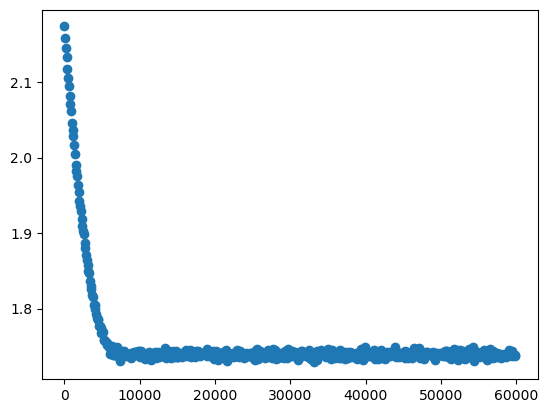

In [23]:
plt.scatter(x,y)